Total # images to process = 10


$$$----Reading Image img1/13.jpg


%%%% IMAGE: CLOSE_ERODE_THRESHOLD, SHAPE: (225, 300) %%%%


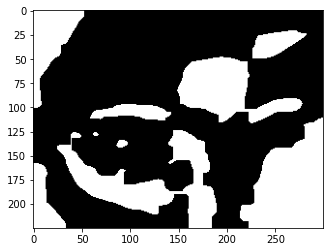

alternate


%%%% IMAGE: GALLBLADDER_MASK, SHAPE: (225, 300) %%%%


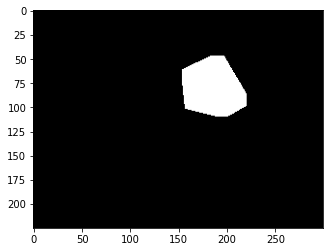

saving mask: 13.png


In [41]:
import os
import cv2 as cv
import json
from glob import glob
import numpy as np
import argparse
import matplotlib.pyplot as plt


''' DEFINE GLOBAL VARIABLES '''
RECT_KERNEL_5X5 = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
RECT_KERNEL_3X3 = cv.getStructuringElement(cv.MORPH_RECT,(3,3))


''' UTIL FUNCTIONS '''
def hconcat_images(image_list):
    '''Concat images horizontally'''
    return cv.hconcat(image_list)

def show_image(img, title='Default', save=False):
    '''Display and save image'''
    if img is None:
        print('Could not find image to show.')
    else:        
        print("\n\n%%%% IMAGE: {}, SHAPE: {} %%%%".format(title, img.shape))
        fig = plt.figure(0)
        plt.imshow(img, cmap='gray')
        plt.show()
        if save:
            fig.savefig("plots/"+title+".png", dpi=300, format="png")        
    return

def save_mask(mask, name):
    '''Save Mask'''
    path = os.path.join(det_path,name+".png")
    print("saving mask: %s.png"%name)
    cv.imwrite(path,mask)
    return


''' CV FUNCTIONS '''

def convert_grayscale(img):
    '''Convert To Grayscale'''
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def bilateral_filter(img, d_val=9,color=100,space=100,border=cv.BORDER_REPLICATE):
    '''
    Bilateral Filter: 
    Image smoothing, Noise Reduction, Edges preserved
    '''
    filtered_img = cv.bilateralFilter(img, d=d_val,sigmaColor=color,sigmaSpace=space,borderType=border)
    return filtered_img

def apply_clahe(img, limit=1, grid=(8,8)):
    '''
    CLAHE:
    Histogram Equalization and Contrast enhancement
    '''
    if len(img.shape) != 2:
        img = convert_grayscale(img)
        print("Converted to Grayscale")
    
    clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=grid)
    improved_hist_img = clahe.apply(img)

    return improved_hist_img

def erode_img(img, window_size = 5, iter=2):
    '''
    MORPHOLOGICAL OPERATION: EROSION
    '''
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3

    eroded_img = cv.erode(img, kernel, iterations = iter)

    return eroded_img

def dilate_img(img, window_size = 5, iter = 2):
    '''
    MORPHOLOGICAL OPERATION: DILATION
    '''
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3
    
    dilated_img = cv.dilate(img, kernel, iterations = iter)

    return dilated_img

def img_thresholding(img, th=60, color=255):
    '''
    Image Thresholding:
    Returns Inverse Binary Threshold.
    '''

    _, th_img = cv.threshold(img,th,color,cv.THRESH_BINARY_INV)

    return th_img

def morphology_ex(img, type, window_size = 3, iter = 2):
    '''
    MORPHOLOGICAL OPERATION: OPEN and CLOSE
    '''
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3
    
    if type == "close":
        morph = cv.MORPH_CLOSE
    elif type == "open":
        morph = cv.MORPH_OPEN

    morphed_img = cv.morphologyEx(img, morph, kernel, iterations = iter) 

    return morphed_img

def canny_detection(img,th1=45, th2=45,aperture=3,l2_grad=False):
    '''
    CANNY EDGE DETECTION:
    Returns: Edge Contours
    '''
    canny_edges = cv.Canny(img,threshold1=th1, threshold2=th2,apertureSize=aperture,L2gradient=l2_grad)

    return canny_edges

def find_contours(img):
    '''
    Find all the contours in an image.
    Returns: List and Hierarchy of all the contours detected
    '''
    hierarchy, contours = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)

    return hierarchy, contours

def get_gallbladder_ctr(ctr, top_n = 5, min_area = 10000, max_area = 150000):
    '''
    Isolate gallbladder contour from a list of contours
    '''

    ctr = sorted(ctr, key=cv.contourArea) 
    big_ctr = ctr[-top_n:]
    filtered_big_ctr = []
    for c in big_ctr:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            filtered_big_ctr.append(c)
    
    if len(filtered_big_ctr) != 0:
        filtered_big_ctr = sorted(filtered_big_ctr, key=cv.contourArea)
        gb_ctr = filtered_big_ctr[-1]
    else:
        gb_ctr = None

    return gb_ctr

def approximate_contour(gb_ctr, sample_size = 33):
    '''
    Smooths irregular and zig-zag edges of Gallbladder contour
    by sampling the edge points at every "sample_size"
    '''
    poly_mask_gb = []    
    for i in range(int(len(gb_ctr)/sample_size)):
        poly_mask_gb.append(gb_ctr[i*sample_size])
    poly_mask_gb.append(gb_ctr[-1])
    poly_mask_gb = np.array(poly_mask_gb)

    return poly_mask_gb

def draw_contour(mask_ctr, height, width):
    '''
    Draw and fill the contour on the canvas as the same size of the image (H,W)
    '''
    canvas = np.zeros((height, width), dtype=np.uint8)
    if not mask_ctr is None:
        cv.drawContours(canvas, [mask_ctr], -1, (255,255,255), -1)

    return canvas

def draw_central_mask(img, height, width):
    '''
    ALternate Approach in case no contour detected
    '''
    canvas = np.zeros((height, width), dtype=np.uint8)
    center_coordinates = (int(width/2), int(height/2)) 
    axesLength = (int(np.sqrt(height**2+width**2)*0.7*0.5), int(np.sqrt(height**2+width**2)*0.4*0.5)) 
    angle = -30
    startAngle = 0
    endAngle = 360
    color = (255, 255, 255) 
    thickness = -1
    
    canvas = cv.ellipse(canvas, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    img = img.astype(np.uint8)
    bitwise_area = cv.bitwise_and(img, img, mask=canvas)
    bitwise_area = erode_img(bitwise_area)
    Contour, _ = find_contours(bitwise_area)
    ctr = sorted(Contour, key=cv.contourArea)
    ctr = ctr[-1]

    return ctr
def smooth_mask(mask, kernel_size=51):
    '''
    Smooth the irregular edges of the contour
    '''
    blurred_img  = cv.GaussianBlur(mask, (kernel_size, kernel_size), 0)
    
    _, th = cv.threshold(blurred_img, 130, 255, cv.THRESH_BINARY)
    return th

def generate_mask(img): 
    '''
    GENERATE MASK: 
    Driver Function for the Binary Mask Creation for the GallBladder in the given image
    '''
    print("\n\n$$$----Reading Image", img)
    #Read Original Image
    orig_image = cv.imread(img)
    (H,W,C) = orig_image.shape
    #show_image(orig_image, "ORIGINAL_IMAGE", True)

    #Image Smoothing and Noise Reduction
    smooth_img = bilateral_filter(orig_image)
    #show_image(smooth_img, "NOISE_REMOVED", True)

    #Improve contrast and Hist. Equalization
    grayscale_img = convert_grayscale(smooth_img)
    inc_contrast_img = apply_clahe(grayscale_img)
    inc_contrast_img = bilateral_filter(inc_contrast_img)
    #show_image(inc_contrast_img, "CONTRAST_IMPROVED", True)

    #Erode Improved Contrast Image
    erode_im = erode_img(inc_contrast_img, iter=2)
    #show_image(erode_im, "ERODE_IMPROVED_CONTRAST", True)

    #Image Thresholding
    th_img = img_thresholding(erode_im)
    #show_image(th_img, "IMAGE_THRESHOLD", True)

    #Morphological: Close and Erode
    close_th = morphology_ex(th_img, type="close", iter=2)
    erode_close_th = erode_img(close_th, iter=2)
    #show_image(erode_close_th, "CLOSE_ERODE_THRESHOLD", True)

    #Find all contours and isolate Gallbladder contour
    contours, _ = find_contours(erode_close_th)
    gb_ctr = get_gallbladder_ctr(contours)
    if gb_ctr is None:
        print("Alternate Approach")
        gb_ctr = draw_central_mask(erode_close_th, H, W)

    rough_ctr = draw_contour(gb_ctr, H, W)
    gaussian_mask = dilate_img(rough_ctr, iter=2)
    gaussian_mask = smooth_mask(gaussian_mask, 101)

    #show_image(rough_ctr, "ROUGH_CONTOUR", True)
    enhanced_gb_ctr = approximate_contour(gb_ctr, sample_size = 32)

    #Draw the Smooth Gallbladder Mask
    gb_mask = draw_contour(enhanced_gb_ctr, H, W)
    gb_mask = dilate_img(gb_mask, iter=2)

    #common mask Gaussian + Sampled smoothed
    common_smooth_mask = cv.bitwise_or(gaussian_mask, gb_mask)
    common_smooth_mask = dilate_img(common_smooth_mask, iter=1)
    #show_image(gb_mask, "GALLBLADDER_MASK", True)
    
    save_mask(common_smooth_mask, img.split("/")[-1][:-4])

    return

if __name__ == "__main__":
   
    
    img_path = "img"
    det_path = "det"
    images = glob(os.path.join(img_path,"*"))

    print("Total # images to process =", len(images))

    #for img in images:
    '''for img in images:
        generate_mask(img)'''
    #generate_mask("img1/13.jpg")



%%%% IMAGE: Default, SHAPE: (844, 1168) %%%%


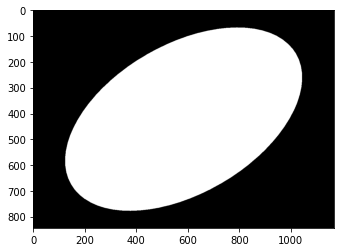

In [31]:
(height, width) = (844, 1168)
canvas = np.zeros((height, width), dtype=np.uint8)
center_coordinates = (int(width/2), int(height/2)) 
axesLength = (int(np.sqrt(height**2+width**2)*0.7*0.5), int(np.sqrt(height**2+width**2)*0.4*0.5))     
angle = -30
startAngle = 0
endAngle = 360
color = (255, 255, 255) 
thickness = -1

canvas = cv.ellipse(canvas, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
show_image(canvas)